In [63]:
%load_ext autoreload

from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys
sys.path.append("../scripts/")  # Add the scripts folder to the path
from load_data import load_data_from_postgres, load_data_using_sqlalchemy
from data_preprocessing import clean_data, handle_outliers
from visualizations import visualize_clusters
from data_transform import convert_bytes_to_mb, rename_columns
from experience_analytics import (
    aggregate_customer_data,
    compute_top_bottom_frequent,
    analyze_throughput_per_handset,
    perform_kmeans_clustering
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
%autoreload 2

In [10]:
# Load environment variables from .env file
load_dotenv()

# Fetch database connection parameters from environment variables
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")

In [11]:
# Define your SQL query
query = "SELECT * FROM xdr_data;"

# Load data from PostgreSQL using SQLAlchemy
df = load_data_using_sqlalchemy(query)

# Display the first few rows of the dataframe
if df is not None:
    print("Successfully loaded the data")
else:
    print("Failed to load data.")

Successfully loaded the data


In [12]:
telecom_data = clean_data(df)
print(telecom_data.info())
print(telecom_data.isnull().sum())  
print(telecom_data.shape)         


<class 'pandas.core.frame.DataFrame'>
Index: 148488 entries, 0 to 149999
Data columns (total 46 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Bearer Id                       148488 non-null  object        
 1   Start                           148488 non-null  datetime64[ns]
 2   Start ms                        148488 non-null  float64       
 3   End                             148488 non-null  datetime64[ns]
 4   End ms                          148488 non-null  float64       
 5   IMSI                            148488 non-null  object        
 6   MSISDN/Number                   148488 non-null  object        
 7   IMEI                            148488 non-null  object        
 8   Last Location Name              148488 non-null  category      
 9   Avg RTT DL (ms)                 148488 non-null  float64       
 10  Avg RTT UL (ms)                 148488 non-null  float64     

In [13]:
# Select numeric columns
numeric_columns = telecom_data.select_dtypes(include=['float64', 'int64']).columns

# Treat outliers using the handle_outliers function
telecom_data = handle_outliers(telecom_data, numeric_columns)


In [14]:
# Define the renaming dictionary
rename_dict = {'Dur. (ms).1': 'Dur. (ms)'}

# Rename columns using the rename_columns function
telecom_data = rename_columns(telecom_data, rename_dict)

# Verify the column names
print(telecom_data.columns)


Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'Activity Duration DL (ms)', 'Activity Duration UL (ms)', 'Dur. (ms)',
       'Handset Manufacturer', 'Handset Type', 'Nb of sec with Vol DL < 6250B',
       'Nb of sec with Vol UL < 1250B', 'Social Media DL (Bytes)',
       'Social Media UL (Bytes)', 'Google DL (Bytes)', 'Google UL (Bytes)',
       'Email DL (Bytes)', 'Email UL (Bytes)', 'Youtube DL (Bytes)',
       'Youtube UL (Bytes)', 'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
       'Gaming 

In [20]:
# Check for missing values
telecom_data.isnull().sum()

Bearer Id                         0
Start                             0
Start ms                          0
End                               0
End ms                            0
IMSI                              0
MSISDN/Number                     0
IMEI                              0
Last Location Name                0
Avg RTT DL (ms)                   0
Avg RTT UL (ms)                   0
Avg Bearer TP DL (kbps)           0
Avg Bearer TP UL (kbps)           0
TCP DL Retrans. Vol (Bytes)       0
TCP UL Retrans. Vol (Bytes)       0
DL TP < 50 Kbps (%)               0
50 Kbps < DL TP < 250 Kbps (%)    0
250 Kbps < DL TP < 1 Mbps (%)     0
DL TP > 1 Mbps (%)                0
UL TP < 10 Kbps (%)               0
10 Kbps < UL TP < 50 Kbps (%)     0
50 Kbps < UL TP < 300 Kbps (%)    0
UL TP > 300 Kbps (%)              0
Activity Duration DL (ms)         0
Activity Duration UL (ms)         0
Dur. (ms)                         0
Handset Manufacturer              0
Handset Type                

In [28]:
# Aggregate per customer
aggregated_data = aggregate_customer_data(telecom_data)
print("Aggregated Customer Data:")
print(aggregated_data.head())

Aggregated Customer Data:
   MSISDN/Number  TCP DL Retrans. Vol (Bytes)  TCP UL Retrans. Vol (Bytes)  \
0   3.360100e+10                 2.081339e+07                759850.598148   
1   3.360100e+10                 2.081339e+07                759850.598148   
2   3.360100e+10                 2.081339e+07                759850.598148   
3   3.360101e+10                 1.066000e+03                759850.598148   
4   3.360101e+10                 1.508151e+07                390526.299074   

   Avg RTT DL (ms)  Avg RTT UL (ms)  Avg Bearer TP DL (kbps)  \
0        46.000000         0.000000                     37.0   
1        30.000000         1.000000                     48.0   
2       109.796253        17.662883                     48.0   
3        69.000000        15.000000                    204.0   
4        57.000000         2.500000                  20197.5   

   Avg Bearer TP UL (kbps)                    Handset Type  
0                     39.0  Huawei P20 Lite Huawei Nova 3E 

In [41]:
# Compute top, bottom, and frequent values
tcp_rtt_throughput_summary = compute_top_bottom_frequent(df)
print("TCP Summary: top 10 TCP values in the dataset.\n  TCP DL Retrans. Vol (Bytes)\n", tcp_rtt_throughput_summary['tcp_top'])
print("\nRTT Summary: top 10 RTT values in the dataset\n Avg RTT DL (ms)\n", tcp_rtt_throughput_summary['rtt_top'])
print("\nThroughput Summary: top 10 Throughput values in the dataset.\n Avg Bearer TP DL (kbps)\n", tcp_rtt_throughput_summary['throughput_top'])

TCP Summary: top 10 TCP values in the dataset.
  TCP DL Retrans. Vol (Bytes)
 77979     4.294426e+09
135678    4.291380e+09
34645     4.289877e+09
140813    4.289488e+09
3782      4.288060e+09
119684    4.275259e+09
39637     4.268432e+09
76990     4.259997e+09
59016     4.256650e+09
41209     4.254644e+09
Name: TCP DL Retrans. Vol (Bytes), dtype: float64

RTT Summary: top 10 RTT values in the dataset
 Avg RTT DL (ms)
 30166     96923.0
29927     64640.0
17910     55811.0
5989      54847.0
22851     26971.0
23455     26250.0
1373      25873.0
81274     25602.0
97321     25374.0
100584    24733.0
Name: Avg RTT DL (ms), dtype: float64

Throughput Summary: top 10 Throughput values in the dataset.
 Avg Bearer TP DL (kbps)
 120890    378160.0
141262    299257.0
143670    299002.0
149617    276040.0
92193     269362.0
117791    266332.0
115850    265440.0
89577     264448.0
116565    263047.0
41576     254253.0
Name: Avg Bearer TP DL (kbps), dtype: float64


In [40]:
# Compute top, bottom, and frequent values
tcp_rtt_throughput_summary = compute_top_bottom_frequent(df)
print("TCP Summary: bottom 10 TCP values in the dataset.\n  TCP DL Retrans. Vol (Bytes)\n", tcp_rtt_throughput_summary['tcp_bottom'])
print("\nRTT Summary:bottom 10 RTT values in the dataset\n  Avg RTT DL (ms)\n", tcp_rtt_throughput_summary['rtt_bottom'])
print("\nThroughput Summary: bottom 10 Throughput values in the dataset.\n Avg Bearer TP DL (kbps)\n ", tcp_rtt_throughput_summary['throughput_bottom'])

TCP Summary: bottom 10 TCP values in the dataset.
  TCP DL Retrans. Vol (Bytes)
 59717     2.0
125094    2.0
2850      4.0
39610     4.0
52488     4.0
60376     4.0
60426     4.0
75093     4.0
100314    4.0
143429    4.0
Name: TCP DL Retrans. Vol (Bytes), dtype: float64

RTT Summary:bottom 10 RTT values in the dataset
  Avg RTT DL (ms)
 42612     0.0
52225     0.0
60152     0.0
61152     0.0
61345     0.0
103328    0.0
124544    0.0
142526    0.0
143878    0.0
71739     2.0
Name: Avg RTT DL (ms), dtype: float64

Throughput Summary: bottom 10 Throughput values in the dataset.
 Avg Bearer TP DL (kbps)
  13      0.0
149     0.0
364     0.0
546     0.0
618     0.0
679     0.0
756     0.0
809     0.0
893     0.0
1185    0.0
Name: Avg Bearer TP DL (kbps), dtype: float64


In [36]:
# Compute top, bottom, and frequent values
tcp_rtt_throughput_summary = compute_top_bottom_frequent(df)
print("TCP Summary:10 most frequen TCP values in the dataset.\n ", tcp_rtt_throughput_summary['tcp_freq'])
print("\nRTT Summary:10 most frequen RTT values in the dataset\n", tcp_rtt_throughput_summary['rtt_freq'])
print("\nThroughput Summary: 10 most frequen Throughput values in the dataset.\n", tcp_rtt_throughput_summary['throughput_freq'])

TCP Summary:10 most frequen TCP values in the dataset.
 TCP DL Retrans. Vol (Bytes)
1330.0    433
2660.0    219
38.0      200
92.0      192
1318.0    156
543.0     133
3990.0    114
76.0      108
5320.0    102
1288.0     93
Name: count, dtype: int64

RTT Summary:10 most frequen RTT values in the dataset
 Avg RTT DL (ms)
28.0    3553
27.0    3380
34.0    3296
35.0    2892
37.0    2718
36.0    2645
38.0    2547
29.0    2498
26.0    2488
33.0    2430
Name: count, dtype: int64

Throughput Summary: 10 most frequen Throughput values in the dataset.
 Avg Bearer TP DL (kbps)
23.0    7324
43.0    4352
44.0    4186
6.0     3983
22.0    2867
48.0    2778
63.0    2757
42.0    2689
45.0    2644
47.0    2263
Name: count, dtype: int64


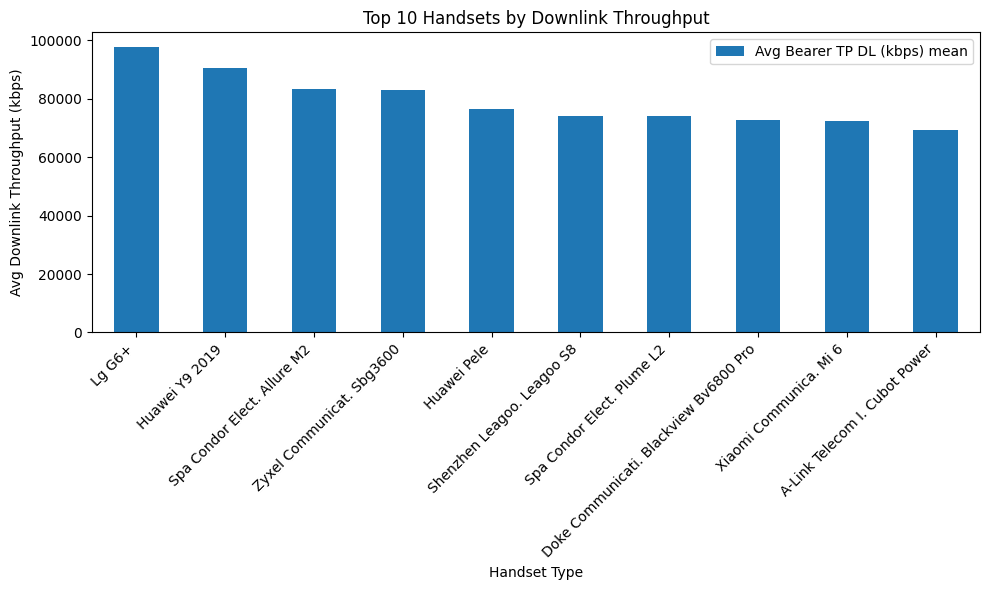

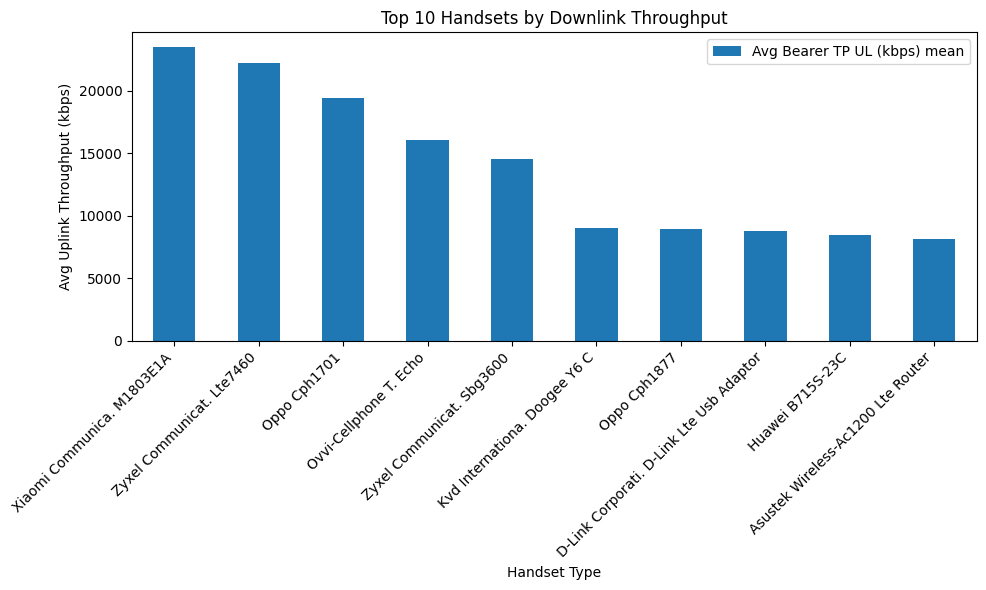

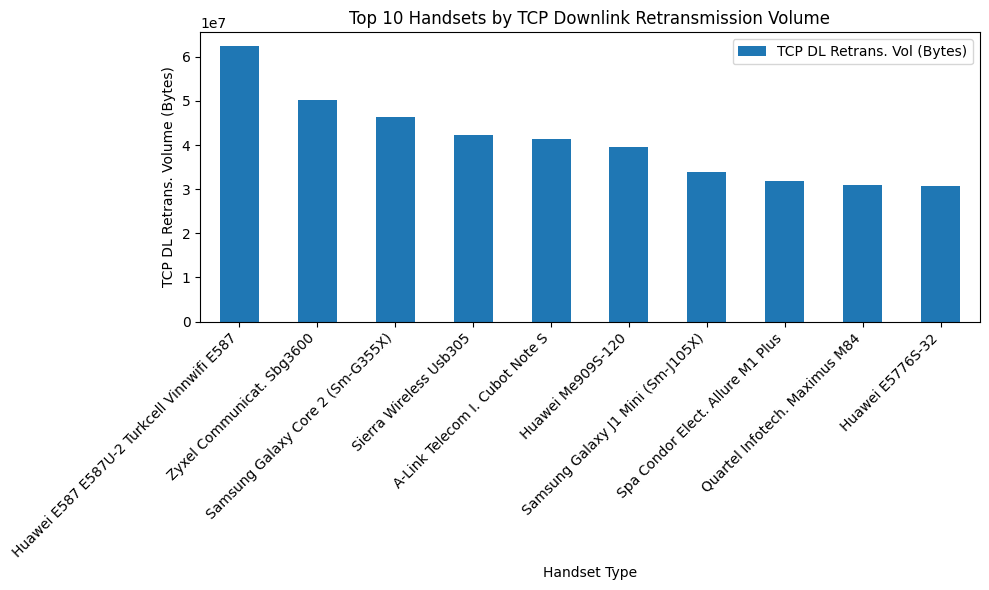

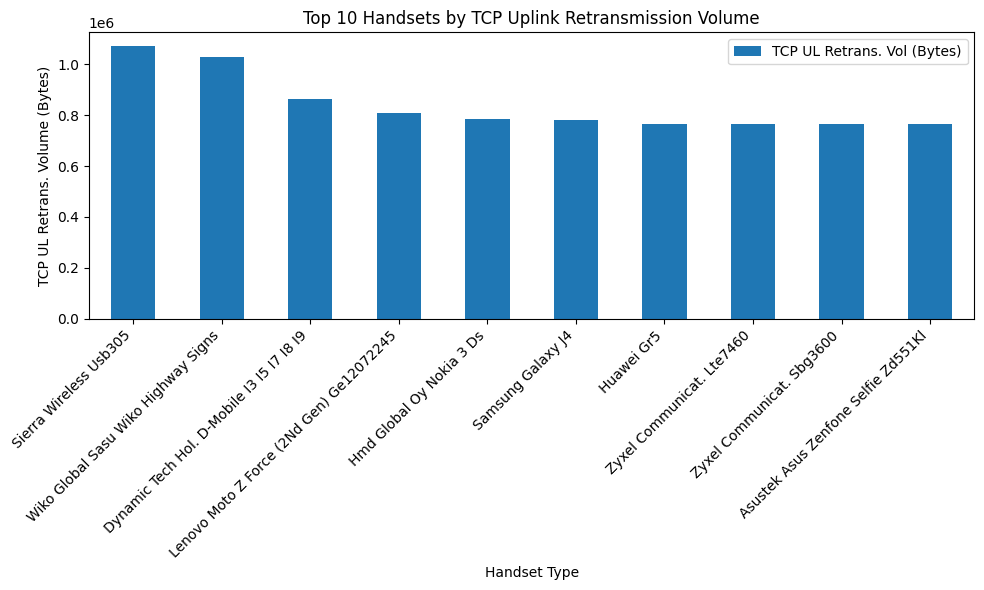

Throughput Distribution per Handset Type:
                                           Handset Type  \
0                            A-Link Telecom I. Cubot A5   
1                     A-Link Telecom I. Cubot Note Plus   
2                        A-Link Telecom I. Cubot Note S   
3                          A-Link Telecom I. Cubot Nova   
4                         A-Link Telecom I. Cubot Power   
...                                                 ...   
1391  Zte Zte Blade C2 Smartphone Android By Sfr Sta...   
1392                          Zyxel Communicat. Lte7460   
1393                          Zyxel Communicat. Sbg3600   
1394                    Zyxel Communicat. Zyxel Wah7706   
1395                                          undefined   

      Avg Bearer TP DL (kbps) count  Avg Bearer TP DL (kbps) mean  \
0                               1.0                  23184.000000   
1                               1.0                   6527.000000   
2                               1.0       

In [61]:
# Call the function and visualize the data
throughput_distribution, tcp_retransmission_per_handset = analyze_throughput_per_handset(aggregated_data)

# Print outputs for further analysis
print("Throughput Distribution per Handset Type:")
print(throughput_distribution)
print("\nAverage TCP Retransmission mean per Handset Type:")
print(tcp_retransmission_per_handset)

Cluster Centers:
[[7.06684684e+01 2.80949834e+03 2.14329605e+07]
 [1.04716208e+02 2.33670110e+04 9.66079087e+05]
 [7.76345499e+01 1.92294269e+04 1.09931966e+07]]
Clustered Data:
   MSISDN/Number  Cluster
0   3.360100e+10        0
1   3.360100e+10        0
2   3.360100e+10        0
3   3.360101e+10        1
4   3.360101e+10        2


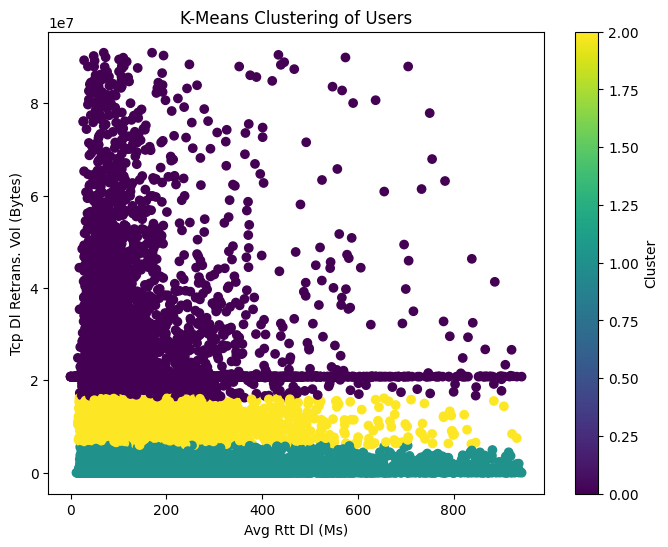

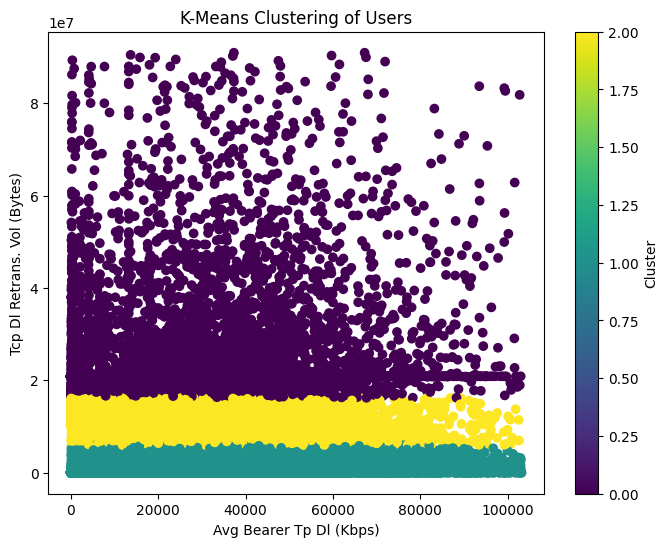

In [67]:
# K-Means clustering
clustered_data, cluster_centers = perform_kmeans_clustering(aggregated_data)
print("Cluster Centers:")
print(cluster_centers)
print("Clustered Data:")
print(clustered_data[['MSISDN/Number', 'Cluster']].head())
'Avg RTT DL (ms)', 'Avg Bearer TP DL (kbps)', 'TCP DL Retrans. Vol (Bytes)'
# Visualize the clusters
visualize_clusters(aggregated_data, 'Avg RTT DL (ms)', 'TCP DL Retrans. Vol (Bytes)')
visualize_clusters(aggregated_data, 'Avg Bearer TP DL (kbps)', 'TCP DL Retrans. Vol (Bytes)')